In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
from uncertainty import MCP_unc, entropy
from uncertainty import metrics

# Base Model

## Definitions

In [5]:
MODEL_ARC = 'ResNet50'#WideResNet ResNet101,ResNet18,ResNet34,ResNet50 CNN8
DATA = 'Cifar100'
NAME = f'{MODEL_ARC}_{DATA}_g'

In [6]:
TRAIN = False

In [7]:
VAL_SIZE = 0.1

loss_criterion = nn.CrossEntropyLoss()
risk_dict = None#{'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}

data_params = {'train_batch_size': 128, 'validation_size': VAL_SIZE, 'test_batch_size': 100}

In [8]:
CREATE_DIR = True #If true, creates directories to save model (weights_path)
LIVE_PLOT = True #If True, plot* loss while training. If 'print', print loss per epoch
SAVE_CHECKPOINT = True #If True, save (and update) model weights for the best epoch (smallest validation loss)
SAVE_ALL = False #If True, saves weights and trainer at the end of training

In [9]:
data = torch_data.__dict__[DATA](data_dir = DATA_PATH,validation_as_train = True,params = data_params)
num_classes = data.n_classes
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA, 'Uncertainty_Regressor')

if CREATE_DIR and not os.path.isdir(weights_path):
    os.makedirs(weights_path)

Files already downloaded and verified
Files already downloaded and verified


## Upload Base Model

In [10]:
if not TRAIN:
    if DATA == 'ImageNet':
        weights = models.pretrained_models[model_class]
        pre_model = model_class(weights = weights).to(dev)
        data.transforms_test = weights.transforms()
    else:
        pre_model = model_class(num_classes = data.n_classes).to(dev)
        pre_model.load_state_dict(utils.upload_weights(weights_path))

## Train Base Model

In [11]:
N_EPOCHS_0 = 200
if TRAIN:
    loss_criterion = nn.CrossEntropyLoss()
    pre_model = model_class(num_classes = data.n_classes).to(dev)
    pre_model.name = f'{MODEL_ARC}_{DATA}_Val{int(VAL_SIZE*100)}'
    optimizer = torch.optim.SGD(pre_model.parameters(), lr =0.1,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS_0)
    model_trainer = TE.Trainer(pre_model,optimizer,loss_criterion, None,data.test_dataloader,lr_scheduler = scheduler)
    model_trainer.fit(data.train_dataloader,N_EPOCHS_0, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)

## Base Model

In [12]:
pre_model.eval()
acc = TE.model_acc(pre_model,data.train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(pre_model,data.validation_dataloader)
print('Conjunto de validação: acc = ', acc)
acc = TE.model_acc(pre_model,data.test_dataloader)
print('Conjunto de teste: acc = ', acc)

Conjunto de treinamento: acc =  99.96888888888888
Conjunto de validação: acc =  77.08
Conjunto de teste: acc =  78.32


# Temperature Analysis

## Model Definition

In [13]:
from uncertainty.calibration import Platt_Model, _ECELoss

model = Platt_Model(pre_model)

In [14]:
c_list = np.arange(0.05,1.05,0.05)
output,label = TE.accumulate_results(pre_model,data.test_dataloader)

## Results

### Metrics

In [15]:
def entropy(y):
    '''Returns the entropy of a probabilities tensor.'''
    
    entropy = torch.special.entr(y) #entropy element wise
    entropy = torch.sum(entropy,-1)
    
    return entropy

In [17]:
from uncertainty import get_MCP,entropy,MCP_unc
beta_range = np.around(np.append(np.arange(0.1,1,0.05),np.arange(1,5.1,0.05)),2)
ECE = _ECELoss(n_bins = 10)

RC_mcps = dict.fromkeys(np.around(beta_range,2))
RC_entropys = dict.fromkeys(np.around(beta_range,2))
mcps = dict.fromkeys(beta_range)
entropys = dict.fromkeys(beta_range)
eces = []

for beta in np.around(beta_range,2):
    y_pred = torch.nn.functional.softmax(output*beta,dim=-1)
    RC_mcp = metrics.RC_curve(y_pred,label,MCP_unc(y_pred),c_list = c_list)
    RC_mcps[beta] = RC_mcp
    RC_entropy = metrics.RC_curve(y_pred,label,entropy(y_pred),c_list = c_list)
    RC_entropys[beta] = RC_entropy
    eces.append(ECE(output*beta,label).item())
    mcps[beta] = get_MCP(y_pred).cpu().numpy()
    entropys[beta] = entropy(y_pred).cpu().numpy()

In [18]:
def AURC_dict(d:dict, c_list):
    RC = np.stack(list(d.values()))
    aurc = np.trapz(RC,x=c_list,axis=-1)
    return aurc
def best_RC(d):
    RC = np.stack(list(d.values()))
    return np.min(RC,axis=0),np.array(list(d.keys()))[np.argmin(RC,axis=0)]
def worst_RC(d):
    RC = np.stack(list(d.values()))
    return np.max(RC,axis=0),np.array(list(d.keys()))[np.argmax(RC,axis=0)]

In [19]:
AURC_mcp = AURC_dict(RC_mcps,c_list)
AURC_ent = AURC_dict(RC_entropys,c_list)
RC_mcp_opt, beta_mcp_opt = best_RC(RC_mcps)
RC_ent_opt, beta_ent_opt = best_RC(RC_entropys)
RC_mcp_worst, beta_mcp_worst = worst_RC(RC_mcps)
RC_ent_worst, beta_ent_worst = worst_RC(RC_entropys)

### Plots

#### RC per $\beta$

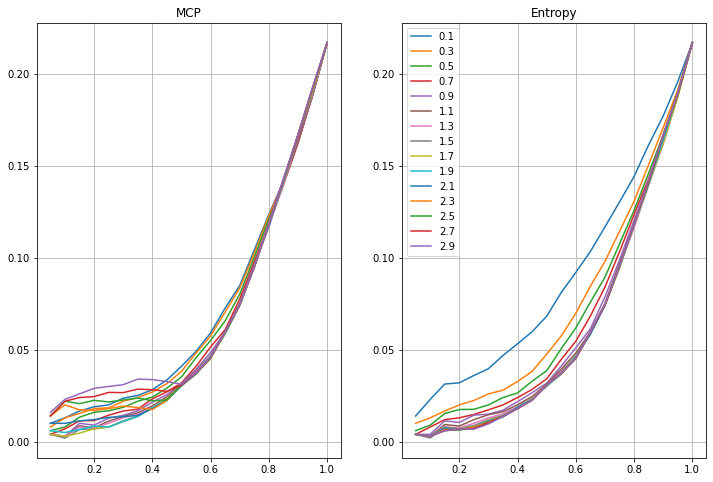

In [20]:
fig,axs = plt.subplots(1,2,figsize=(12, 8))

for beta in np.around(np.arange(0.1,3,0.2),2):
    axs[0].plot(c_list,RC_mcps[beta],label = f'{beta:.1f}')
    axs[1].plot(c_list,RC_entropys[beta],label = f'{beta:.1f}')
    
    
axs[0].set_title('MCP')
axs[1].set_title('Entropy')
axs[0].grid()
axs[1].grid()
plt.legend()
plt.show()

#### Optimal x Default

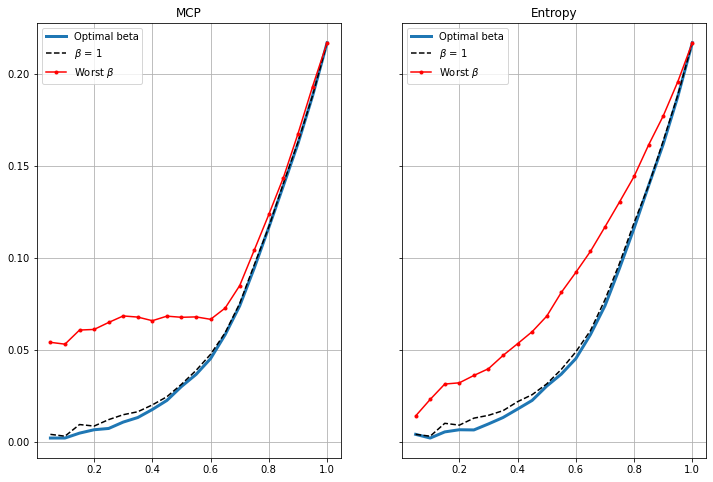

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey = True,figsize = (12,8))

ax1.plot(c_list,RC_mcp_opt, label = 'Optimal beta', linewidth = 3)
ax1.plot(c_list,RC_mcps[1.0], 'k--',label = r'$\beta$ = 1')
ax1.plot(c_list,RC_mcp_worst, 'r.-',label = r'Worst $\beta$')
ax1.grid()
ax1.legend()
ax1.set_title('MCP')

ax2.plot(c_list,RC_ent_opt,label = 'Optimal beta', linewidth = 3)
ax2.plot(c_list,RC_entropys[1.0], 'k--',label = r'$\beta$ = 1')
ax2.plot(c_list,RC_ent_worst,'r.-',label = r'Worst $\beta$')
ax2.grid()
ax2.legend()
ax2.set_title('Entropy')
plt.show()

#### Optimal MCP x Optimal Entropy

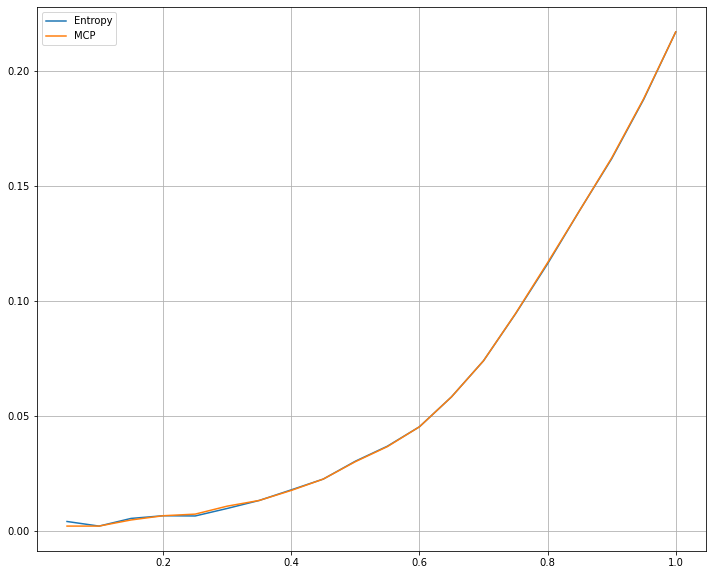

In [22]:

plt.figure(figsize = (12,10))
plt.plot(c_list,RC_ent_opt,label = 'Entropy')
plt.plot(c_list,RC_mcp_opt,label = 'MCP')
plt.grid()
plt.legend()
plt.show()



#### AURC

Text(0.5, 1.0, 'AURC x $\\beta$')

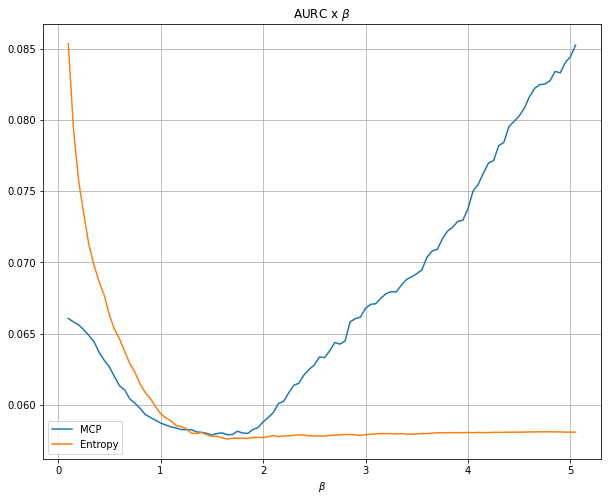

In [23]:
plt.figure(figsize=(10,8))
plt.plot(beta_range,AURC_mcp,label = 'MCP')
plt.plot(beta_range,AURC_ent, label = 'Entropy')
plt.xlabel(r'$\beta$')
plt.grid()
plt.legend()
plt.title(r'AURC x $\beta$')

#### Iterative $\beta$

In [24]:
from ipywidgets import interactive,IntSlider
%matplotlib inline
fig = plt.figure()

def plot_RC_widget(beta=1.0):
    plt.plot(c_list,RC_mcps[beta],label = 'MCP')
    plt.plot(c_list,RC_entropys[beta], label = 'Entropy')
    
    fig.canvas.draw_idle()
    plt.ylim(0,0.22)
    plt.grid()
    plt.legend()
    plt.show()
interactive_plot = interactive(plot_RC_widget,beta=(0.1,5,0.05))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='beta', max=5.0, min=0.1, step=0.05), Output()), _dom…

<Figure size 432x288 with 0 Axes>

In [25]:
from ipywidgets import interactive,IntSlider
%matplotlib inline
fig = plt.figure()

def plot_entropy_widget(beta=1.0):
    plt.hist(entropys[beta],density = True);
    
    fig.canvas.draw_idle()
    plt.grid()
    plt.legend()
    plt.show()
def plot_MCP_widget(beta=1.0):
    plt.hist(mcps[beta], density = True);
    
    fig.canvas.draw_idle()
    plt.grid()
    #plt.legend()
    plt.show()
interactive_plot = interactive(plot_MCP_widget,beta=(0.1,5,0.05))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='beta', max=5.0, min=0.1, step=0.05), Output()), _dom…

<Figure size 432x288 with 0 Axes>

#### Difference between MCP and Entropy

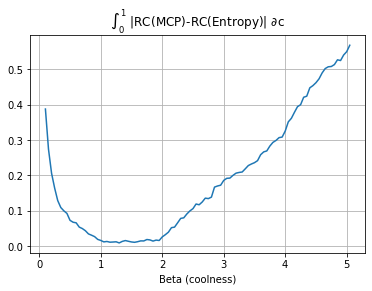

In [26]:
difs = []
for beta in np.around(beta_range,2):
    dif = np.sum(np.abs(RC_mcps[beta]-RC_entropys[beta]))
    difs.append(dif)
plt.plot(beta_range,difs)
plt.grid()
plt.xlabel('Beta (coolness)')
plt.title(r'$\int_0^1$ |RC(MCP)-RC(Entropy)| $\partial$c')
plt.show()


#### Calibration

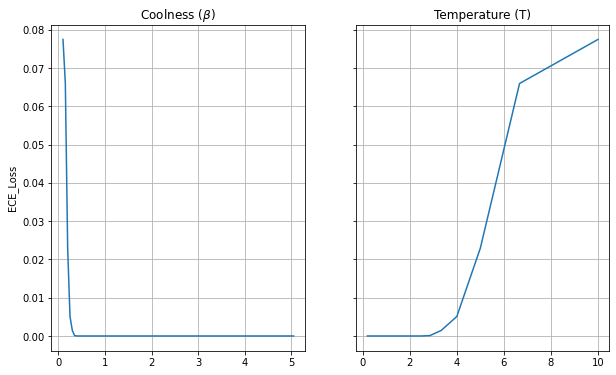

In [27]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),sharey=True)
ax0.plot(beta_range,eces)
ax0.set_ylabel('ECE_Loss')
ax0.set_title(r'Coolness ($\beta$)')
ax0.grid()
ax1.plot(1/beta_range,eces)
ax1.set_title('Temperature (T)')
ax1.grid()
plt.show()

In [28]:
calibrated_beta = beta_range[np.argmin(eces)]
print(f'Best (calibration) empirical T = {1/calibrated_beta}')
print(r'Best (calibration) empirical $\beta$ = ', str(calibrated_beta))

Best (calibration) empirical T = 2.5
Best (calibration) empirical $\beta$ =  0.4
